In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-02-21 025043.png
/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-01-28 235948.png
/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-02-11 220529.png
/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-03-07 061213.png
/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-02-21 051459.png
/kaggle/input/skintype/Skin Types2/Dry_skin/macro-dry-skin-ichthyosis-detail-260nw-1489318061.jpg
/kaggle/input/skintype/Skin Types2/Dry_skin/وصفات_للبشرة_الجافة.jpg
/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-01-28 232531.png
/kaggle/input/skintype/Skin Types2/Dry_skin/dry_37d7c7bd92be29df6dea_jpg.rf.bf56faa4817b7461d2c32177e2ac1550.jpg
/kaggle/input/skintype/Skin Types2/Dry_skin/close-skin-human-260nw-351056246.jpg
/kaggle/input/skintype/Skin Types2/Dry_skin/Screenshot 2025-02-21 021945.png
/kaggle/input/skintype/Skin Types2/Dry_skin/images (2).jpg
/kaggle/input/skintype/Skin Types2/Dry_ski

## Importing libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import random
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay

2025-04-19 17:06:08.390390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745082368.658029      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745082368.730536      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 📂Data Splitting and Directory Setup

In [3]:
# Define paths
dataset_path = "/kaggle/input/skintype/Skin Types2"
output_path = "/kaggle/working/"

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create train, validation, and test directories
train_path = os.path.join(output_path, "train")
val_path = os.path.join(output_path, "val")  
test_path = os.path.join(output_path, "test")

for folder in ["oily_skin", "Dry_skin", "Normal_skin"]:
    os.makedirs(os.path.join(train_path, folder), exist_ok=True)
    os.makedirs(os.path.join(val_path, folder), exist_ok=True)
    os.makedirs(os.path.join(test_path, folder), exist_ok=True)

    # Get all images in the category
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)

    # Filter out corrupted images
    valid_images = []
    for img in images:
        img_path = os.path.join(folder_path, img)
        try:
            with Image.open(img_path) as img_file:
                img_file.verify()
            valid_images.append(img)
        except Exception as e:
            print(f"❌ Skipping corrupted image: {img_path} - Reason: {e}")

    # Shuffle and split images
    random.shuffle(valid_images)
    train_split = int(len(valid_images) * train_ratio)
    val_split = int(len(valid_images) * (train_ratio + val_ratio))

    train_images = valid_images[:train_split]
    val_images = valid_images[train_split:val_split]
    test_images = valid_images[val_split:]

    # Move images to the new directories
    for img in train_images:
        shutil.copy(os.path.join(folder_path, img), os.path.join(train_path, folder, img))

    for img in val_images:
        shutil.copy(os.path.join(folder_path, img), os.path.join(val_path, folder, img))

    for img in test_images:
        shutil.copy(os.path.join(folder_path, img), os.path.join(test_path, folder, img))

print("✅ Data successfully split!")


❌ Skipping corrupted image: /kaggle/input/skintype/Skin Types2/oily_skin/Oily_skin.avif - Reason: cannot identify image file '/kaggle/input/skintype/Skin Types2/oily_skin/Oily_skin.avif'
❌ Skipping corrupted image: /kaggle/input/skintype/Skin Types2/Dry_skin/deccanherald_import_sites_dh_files_article_images_2012_05_04_xerosis.avif - Reason: cannot identify image file '/kaggle/input/skintype/Skin Types2/Dry_skin/deccanherald_import_sites_dh_files_article_images_2012_05_04_xerosis.avif'
✅ Data successfully split!


## Data Preprocessing and Augmentation

In [28]:

train_dir = '/kaggle/working/train/'
val_dir = '/kaggle/working/val/'  
test_dir = '/kaggle/working/test/'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1261 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


## Verifying Class Labels

In [5]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)


{'Dry_skin': 0, 'Normal_skin': 1, 'oily_skin': 2}
{'Dry_skin': 0, 'Normal_skin': 1, 'oily_skin': 2}
{'Dry_skin': 0, 'Normal_skin': 1, 'oily_skin': 2}


## Xception Model and Fine-Tuning Setup

In [29]:
Xception_base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Fine-tuning: Freeze all layers except the last 30
for layer in Xception_base_model.layers[:-30]:
    layer.trainable = False

num_classes = 3  # Number of classes in your dataset

# Add custom layers
x = Xception_base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling layer
x = Dense(1024, activation="relu")(x)  # Fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(512, activation="relu")(x)  # Another fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)# Dropout for regularization
predictions = Dense(num_classes, activation="softmax")(x)  # Output layer

# Create final model
Xception_model = Model(inputs=Xception_base_model.input, outputs=predictions)

## Compiling the Model and Setting Callbacks

In [30]:
Xception_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Fine-tuning requires a lower learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [reduce_lr, early_stopping]

## Training the Xception Model

In [32]:
history = Xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # Try increasing the number of epochs for better performance
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 653ms/step - accuracy: 0.4604 - loss: 1.4138 - val_accuracy: 0.7197 - val_loss: 0.8894 - learning_rate: 1.0000e-04
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 400ms/step - accuracy: 0.6965 - loss: 0.8795 - val_accuracy: 0.7325 - val_loss: 0.7582 - learning_rate: 1.0000e-04
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.8043 - loss: 0.5860 - val_accuracy: 0.7707 - val_loss: 0.6849 - learning_rate: 1.0000e-04
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - accuracy: 0.8183 - loss: 0.5673 - val_accuracy: 0.8280 - val_loss: 0.5438 - learning_rate: 1.0000e-04
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 406ms/step - accuracy: 0.8604 - loss: 0.4267 - val_accuracy: 0.8089 - val_loss: 0.4886 - learning_rate: 1.0000e-04
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - accuracy: 0.8767 - loss: 0.3657 - val_accuracy: 0.8599 - val_loss: 0.3935 - learning_rate: 1.0000e-04
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.87

## ✅Evaluate model on test data

In [33]:

test_loss, test_accuracy = Xception_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.9218 - loss: 0.3468
Test Accuracy: 0.9308176040649414


## 📈Plot accuracy and loss

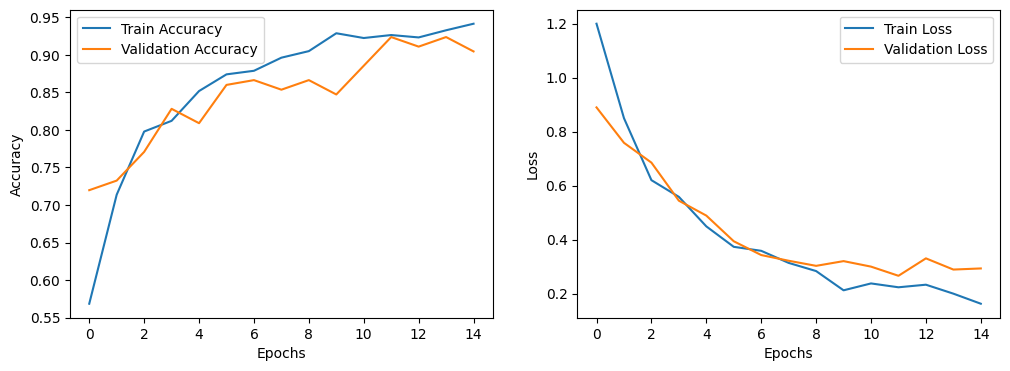

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


## Confusion matrix

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 786ms/step


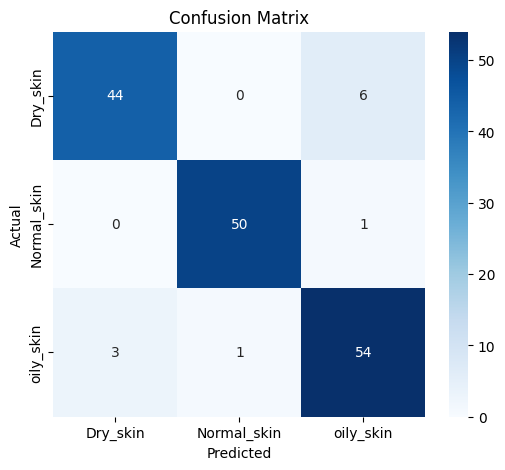

In [35]:
# Get predictions from the model
y_pred = Xception_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = test_generator.classes  # Actual class labels

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 📝Classification report

In [36]:
# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

    Dry_skin       0.94      0.88      0.91        50
 Normal_skin       0.98      0.98      0.98        51
   oily_skin       0.89      0.93      0.91        58

    accuracy                           0.93       159
   macro avg       0.93      0.93      0.93       159
weighted avg       0.93      0.93      0.93       159



## ROC Curve

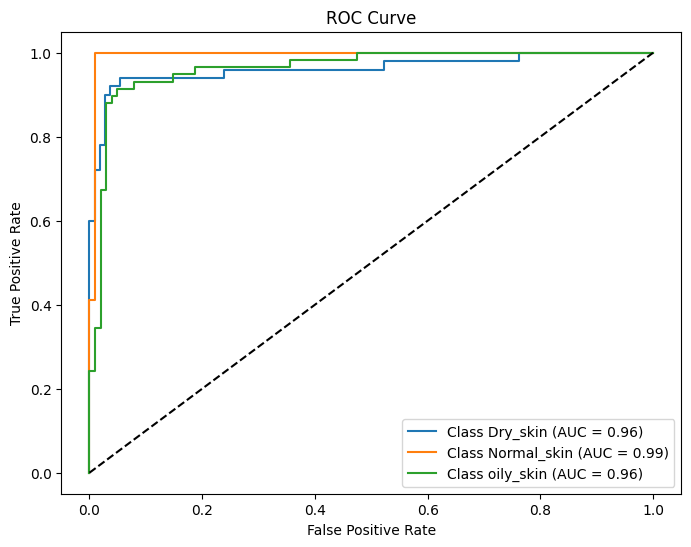

In [37]:
# Convert true labels to One-Hot Encoding format
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Use predicted probabilities instead of class labels
y_pred_proba = y_pred  # Since `predict` returns probabilities, not class labels

# Number of classes
n_classes = len(class_labels)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')
# Plot baseline (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Improve visualization
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## 🖼️Display Random Test Images with Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


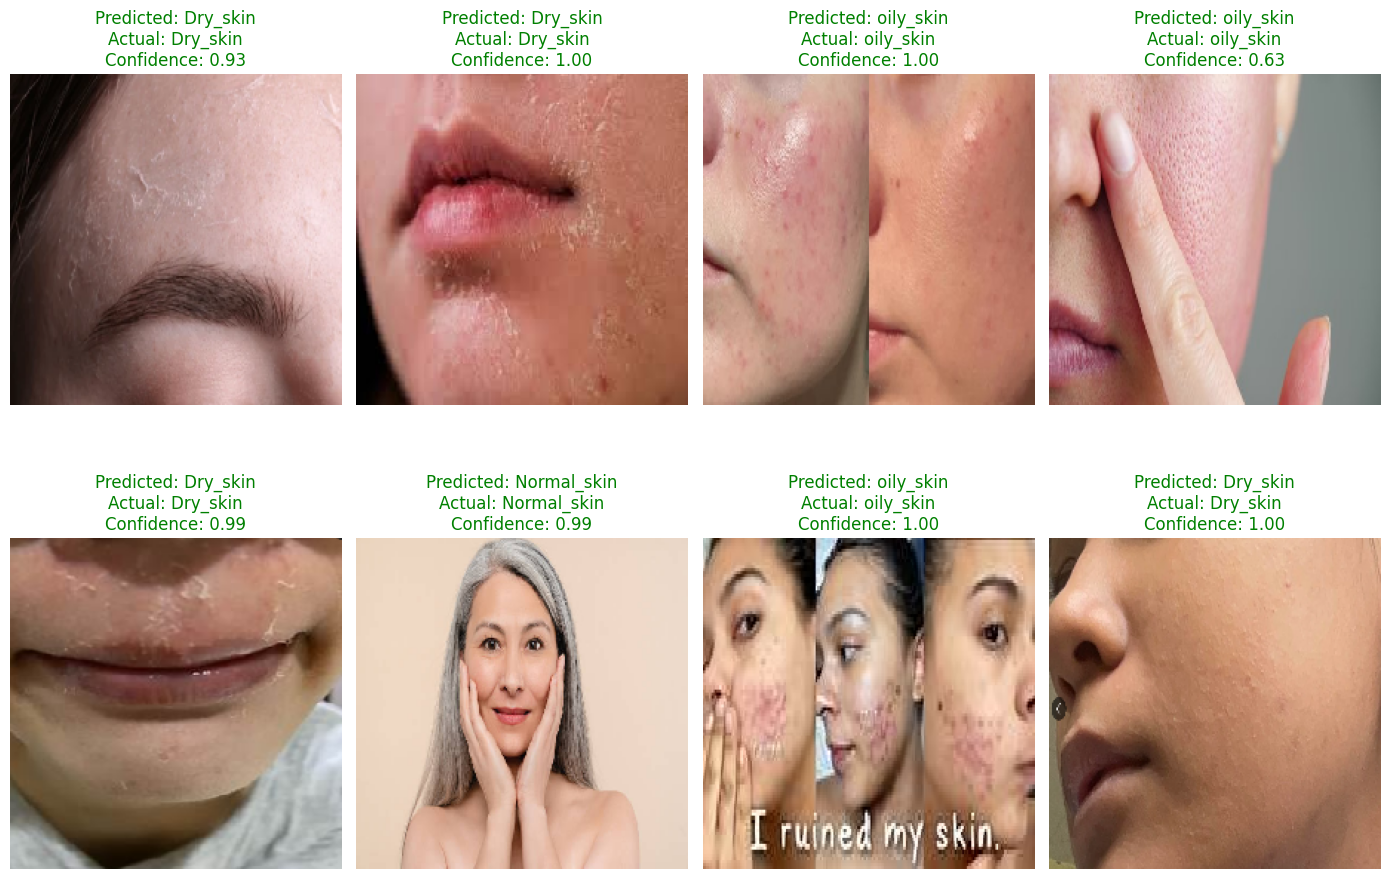

In [40]:
# Get all test image paths
image_paths = test_generator.filepaths  # Paths of images in the test set

# Select 8 random images
random_images = random.sample(image_paths, 8)

# Create a figure for displaying images and predictions
plt.figure(figsize=(14, 10))

for i, img_path in enumerate(random_images):
    # Load the image and preprocess it
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the pixel values

    # Get the actual class from the file path (folder name)
    actual_class = os.path.basename(os.path.dirname(img_path))  

    # Make prediction
    predictions = Xception_model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(test_generator.class_indices.keys())[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    # Determine text color based on correctness
    color = "green" if predicted_class == actual_class else "red"

    # Display image with prediction
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}\nConfidence: {confidence:.2f}", color=color)

plt.tight_layout()
plt.show()


## Save the Trained Model

In [ ]:
Xception_model.save('lastxceptionmodel.keras')

## Load the Saved Model for Future Use

In [ ]:
# from tensorflow.keras.models import load_model
# Xception_model = load_model('lastxceptionmodel.keras')